In [1]:
import h5py
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Masking, TimeDistributed
from keras.optimizers import SGD
from keras import metrics
import matplotlib.pyplot as plt

from python_speech_features import mfcc, logfbank, get_filterbanks
from python_speech_features.sigproc import preemphasis, framesig, powspec


/home/timo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
test_speakers = {
    "MDAB0", "MWBT0", "FELC0",
    "MTAS1", "MWEW0", "FPAS0",
    "MJMP0", "MLNT0", "FPKT0",
    "MLLL0", "MTLS0", "FJLM0",
    "MBPM0", "MKLT0", "FNLP0",
    "MCMJ0", "MJDH0", "FMGD0",
    "MGRT0", "MNJM0", "FDHC0",
    "MJLN0", "MPAM0", "FMLD0"
}

validation_speakers = {
    "FAKS0", "FDAC1", "FJEM0", "MGWT0", "MJAR0",
    "MMDB1", "MMDM2", "MPDF0", "FCMH0", "FKMS0",
    "MBDG0", "MBWM0", "MCSH0", "FADG0", "FDMS0",
    "FEDW0", "MGJF0", "MGLB0", "MRTK0", "MTAA0",
    "MTDT0", "MTHC0", "MWJG0", "FNMR0", "FREW0",
    "FSEM0", "MBNS0", "MMJR0", "MDLS0", "MDLF0",
    "MDVC0", "MERS0", "FMAH0", "FDRW0", "MRCS0",
    "MRJM4", "FCAL1", "MMWH0", "FJSJ0", "MAJC0",
    "MJSW0", "MREB0", "FGJD0", "FJMG0", "MROA0",
    "MTEB0", "MJFC0", "MRJR0", "FMML0", "MRWS1"
}


def split_development_test(test_data):
    validation_keys = []
    core_test_keys = []
    full_test_keys = []
    for key in test_data.keys():
        if key[8:10] == 'SA':
            continue
        if key[3:8] in test_speakers:
            core_test_keys.append(key)
            full_test_keys.append(key)
        elif key[3:8] in validation_speakers:
            validation_keys.append(key)
        else:
            full_test_keys.append(key)
    return validation_keys, core_test_keys, full_test_keys


class TimitGenerator(object):
    def __init__(self, datafile, keys=None, batch_size=20, shuffle=True, mask_value=0.):
        self._datafile = datafile
        self._batch_size = batch_size
        if keys is None:
            self._keys = list(datafile.keys())
        else:
            self._keys = keys
        self._batch_index = 0
        self._shuffle = shuffle
        self._mask_value = mask_value

    def shuffle_keys(self):
        random.shuffle(self._keys)

    def next_sample(self):
        key = self._keys[self._batch_index]
        self._batch_index += 1
        if self._batch_index == len(self._keys):
            self._batch_index = 0
            if self._shuffle:
                self.shuffle_keys()
        return key

    def normalize(self, sequence):
        return (sequence - np.mean(sequence, axis=0)) / np.std(sequence, axis=0)

    def pad_features(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, self._mask_value), (0, 0)))

    def pad_labels(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, 0), (0, 0)))

    def generator(self):
        while True:
            batch_keys = [self.next_sample() for _ in range(self._batch_size)]
            batch_features = [self._datafile[key]['features'] for key in batch_keys]
            batch_labels = [self._datafile[key]['labels'] for key in batch_keys]
            max_length = np.max([f.shape[0] for f in batch_features])

            sample_weights = np.zeros((self._batch_size, max_length), dtype=int)
            for i in range(self._batch_size):
                sample_weights[i, :batch_features[i].shape[0]] = 1

            batch_features = np.array([self.pad_features(self.normalize(f), max_length) for f in batch_features])
            batch_labels = np.array([self.pad_labels(f, max_length) for f in batch_labels])

            yield batch_features, batch_labels, sample_weights

In [3]:
def rnn_model():
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, 13)))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    # TimeDistributed is nodig om het Dense deel op iedere time step toe te passen
    model.add(TimeDistributed(Dense(39, activation='softmax')))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'], sample_weight_mode='temporal')
    return model

In [4]:
class TimitTransformGenerator(object):
    def __init__(self, datafile, transform_func=lambda x: x, keys=None, batch_size=20, shuffle=True, mask_value=0.):
        self._datafile = datafile
        self._batch_size = batch_size
        if keys is None:
            self._keys = list(datafile.keys())
        else:
            self._keys = keys
        self._batch_index = 0
        self._shuffle = shuffle
        self._mask_value = mask_value
        self._transform_func = transform_func

    def shuffle_keys(self):
        random.shuffle(self._keys)

    def next_sample(self):
        key = self._keys[self._batch_index]
        self._batch_index += 1
        if self._batch_index == len(self._keys):
            self._batch_index = 0
            if self._shuffle:
                self.shuffle_keys()
        return key
    
    def pad_features(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, self._mask_value), (0, 0)))

    def pad_labels(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, 0), (0, 0)))

    def generator(self):
        while True:
            batch_keys = [self.next_sample() for _ in range(self._batch_size)]
            batch_features = [self._datafile[key]['features'] for key in batch_keys]
            batch_targets = [self._transform_func(self._datafile[key]['features']) for key in batch_keys]
            max_length = np.max([f.shape[0] for f in batch_features])

            sample_weights = np.zeros((self._batch_size, max_length), dtype=int)
            for i in range(self._batch_size):
                sample_weights[i, :batch_features[i].shape[0]] = 1

            batch_features = np.array([self.pad_features(f, max_length) for f in batch_features])
            batch_targets = np.array([self.pad_labels(f, max_length) for f in batch_targets])

            yield batch_features, batch_targets, sample_weights

In [146]:
def safe_log(features):
    features = np.where(features == 0, np.finfo(float).eps, features)
    return np.log(features)

def normalize(sequence):
    return (sequence - np.mean(sequence, axis=0)) / np.std(sequence, axis=0)

def median_normalize(sequence):
    return (sequence - np.median(sequence, axis=0))

def normalize_scale(sequence):
    return (sequence - np.min(sequence, axis=0)) / (np.max(sequence, axis=0) - np.min(sequence, axis=0))

class TimitTargetGenerator(object):
    def __init__(self, datafile_source, datafile_target, keys=None, batch_size=20, shuffle=True, mask_value=0.):
        self._datafile = datafile_source
        self._datafile_target = datafile_target
        self._batch_size = batch_size
        if keys is None:
            self._keys = list(datafile_source.keys())
        else:
            self._keys = keys
        self._batch_index = 0
        self._shuffle = shuffle
        self._mask_value = mask_value

    def shuffle_keys(self):
        random.shuffle(self._keys)

    def next_sample(self):
        key = self._keys[self._batch_index]
        self._batch_index += 1
        if self._batch_index == len(self._keys):
            self._batch_index = 0
            if self._shuffle:
                self.shuffle_keys()
        return key
    
    def pad_features(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, self._mask_value), (0, 0)))

    def pad_labels(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, 0), (0, 0)))
    
    def generator(self):
        while True:
            batch_keys = [self.next_sample() for _ in range(self._batch_size)]
            batch_features = [normalize_scale(safe_log(self._datafile[key]['features'][()])) for key in batch_keys]
            batch_targets = [normalize_scale(safe_log(self._datafile_target[key]['features'][()])) for key in batch_keys]
            
            max_length = np.max([f.shape[0] for f in batch_features])
            
            sample_weights = np.zeros((self._batch_size, max_length), dtype=int)
            for i in range(self._batch_size):
                sample_weights[i, :batch_features[i].shape[0]] = 1

            batch_features = np.array([self.pad_features(f, max_length) for f in batch_features])
            batch_targets = np.array([self.pad_labels(f, max_length) for f in batch_targets])
            
            yield batch_features, batch_targets, sample_weights

In [147]:
train_data_source_file = '../../TIMIT/1_fft/TRAIN/features.h5'
train_data_target_file = '../../TIMIT/2_preemphasis/TRAIN/features.h5'
test_data_source_file = '../../TIMIT/1_fft/TEST/features.h5'
test_data_target_file = '../../TIMIT/2_preemphasis/TEST/features.h5'

train_data_source = h5py.File(train_data_source_file, 'r')
train_data_target = h5py.File(train_data_target_file, 'r')
test_data_source = h5py.File(test_data_source_file, 'r')
test_data_target = h5py.File(test_data_target_file, 'r')
val_keys, core_test_keys, full_test_keys = split_development_test(test_data_source)

In [148]:
train_generator = TimitTargetGenerator(train_data_source, train_data_target)
validation_generator = TimitTargetGenerator(test_data_source, test_data_target, keys=val_keys, shuffle=False)

In [149]:
feats, targets, sample_weights = next(train_generator.generator())

In [150]:
print(feats.shape, targets.shape, sample_weights.shape)

(20, 475, 257) (20, 475, 257) (20, 475)


In [152]:
(feats < 0).any()

False

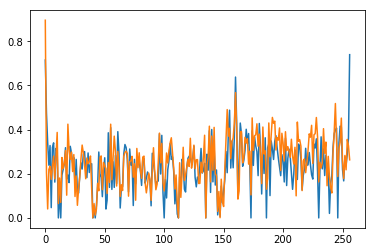

In [153]:
plt.plot(range(257), feats[0, 0, :])
plt.plot(range(257), targets[0, 0, :])
plt.show()

In [106]:
np.isfinite(targets).all()

True

In [117]:
def model():
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, 257)))
    # TimeDistributed is nodig om het Dense deel op iedere time step toe te passen
    model.add(TimeDistributed(Dense(1024, activation='tanh')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1024, activation='tanh')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1024, activation='tanh')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(257, activation='tanh')))
    model.summary()
    sgd = SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[metrics.mae, metrics.mse], sample_weight_mode='temporal')
    return model

In [118]:
m = model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_13 (Masking)         (None, None, 257)         0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, None, 1024)        264192    
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 1024)        0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, None, 1024)        1049600   
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 1024)        0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, None, 1024)        1049600   
_________________________________________________________________
dropout_27 (Dropout)         (None, None, 1024)        0         
__________

In [119]:
m.fit_generator(train_generator.generator(),
                    steps_per_epoch=185,        # ~= 3696 (num training utterances) / 20 (batch size)
                    epochs=20,
                    validation_data=validation_generator.generator(),
                    validation_steps=20,        # = 400 (num validation utterances) / 20 (batch size)
                    callbacks=None)

Epoch 1/20
185/185 [==============================] - 30s 162ms/step - loss: 56.2181 - mean_absolute_error: 4.9543 - mean_squared_error: 34.7090 - val_loss: 55.5263 - val_mean_absolute_error: 4.8282 - val_mean_squared_error: 33.2303
Epoch 2/20
185/185 [==============================] - 24s 129ms/step - loss: 55.7466 - mean_absolute_error: 4.9174 - mean_squared_error: 34.2969 - val_loss: 55.4949 - val_mean_absolute_error: 4.8253 - val_mean_squared_error: 33.2115
Epoch 3/20
185/185 [==============================] - 24s 128ms/step - loss: 55.2838 - mean_absolute_error: 4.9244 - mean_squared_error: 34.3909 - val_loss: 55.4638 - val_mean_absolute_error: 4.8217 - val_mean_squared_error: 33.1930
Epoch 4/20
185/185 [==============================] - 24s 129ms/step - loss: 55.4954 - mean_absolute_error: 4.8994 - mean_squared_error: 34.1518 - val_loss: 55.4348 - val_mean_absolute_error: 4.8177 - val_mean_squared_error: 33.1757
Epoch 5/20
185/185 [==============================] - 24s 128ms/step

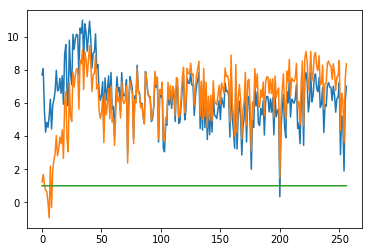

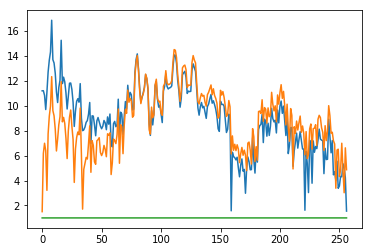

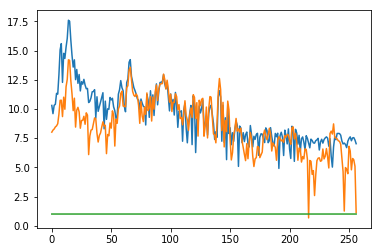

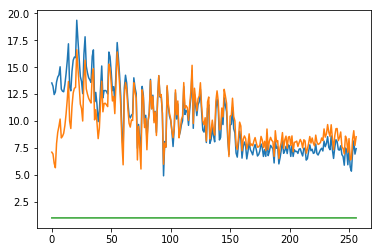

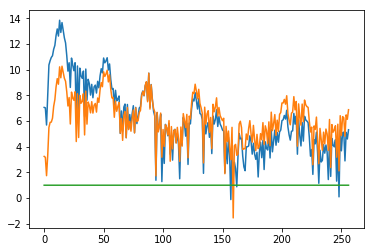

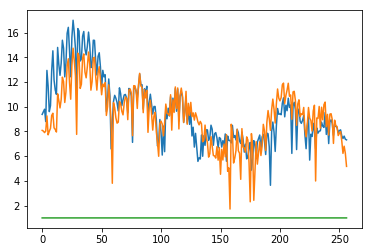

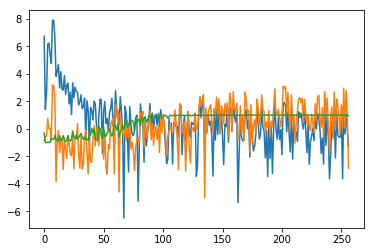

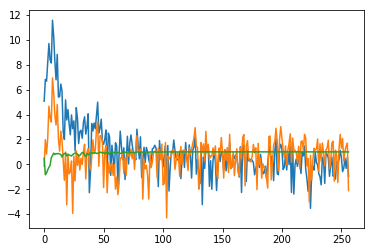

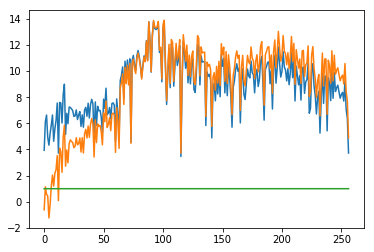

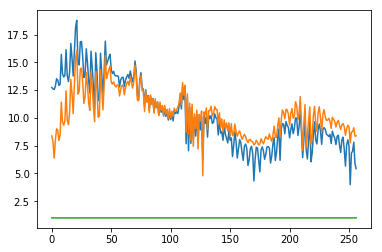

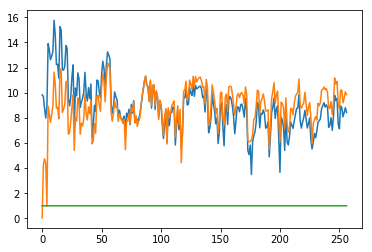

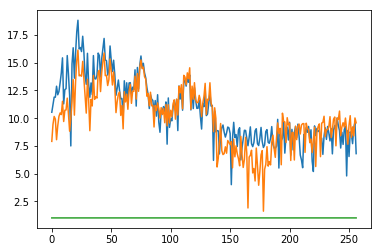

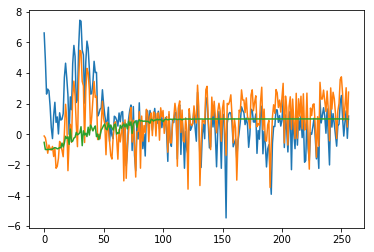

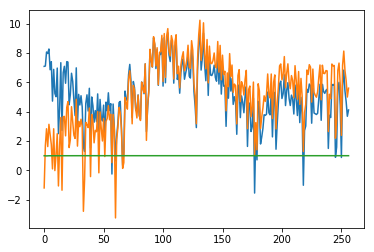

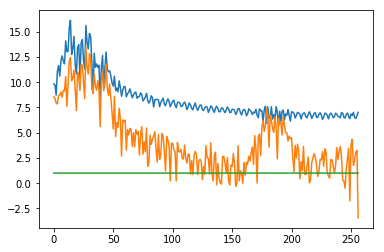

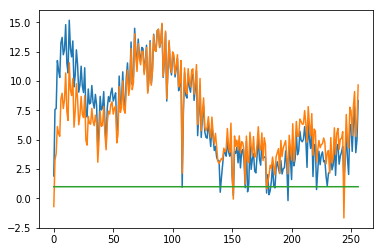

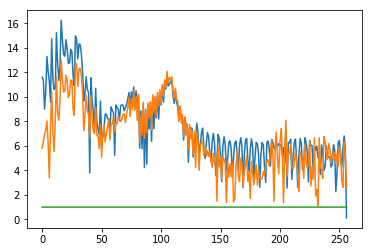

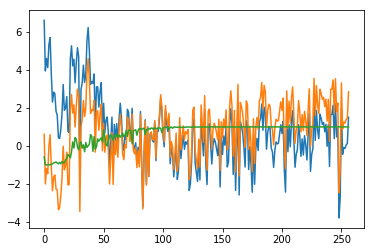

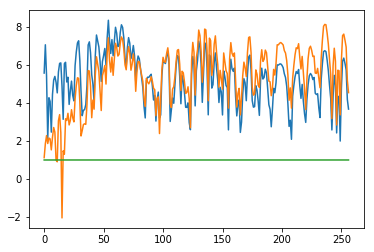

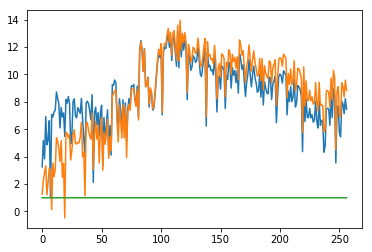

In [123]:
feats, targets, sample_weights = next(validation_generator.generator())
prediction = m.predict(feats)
for i in range(feats.shape[0]):
    plt.plot(range(257), feats[i, 20, :])
    plt.plot(range(257), targets[i, 20, :])
    plt.plot(range(257), prediction[i, 20, :])
    plt.show()

(20, 715, 257)